In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

import casr.src.viz as viz 

In [2]:
COUNTRIES = ["Canada", "United States of America"]
BORDERS = ["Québec"]

In [3]:
provinces = gpd.read_file("casr/data/geojsonfiles/states_provinces.geojson")
countries = gpd.read_file("casr/data/geojsonfiles/ne_110m_admin_0_countries.geojson")

In [4]:
provinces = provinces[provinces["name"].apply(lambda x: x in BORDERS)]
north_america = countries[countries["SOVEREIGNT"].apply(lambda x: x in COUNTRIES)]

---
# Données RCaS

Chargement des maxima de toutes les années.

In [5]:
maxima = viz.load_3darray('casr/data/preprocessed/maxima.bin')
lats_rec = viz.load_matrix('casr/data/viz/lats.bin')
lons_rec = viz.load_matrix('casr/data/viz/lons.bin')

In [6]:
# Année 2022
maxima2022 = maxima[:, :, 42]

Réduction de la taille du jeu de données pour se focaliser sur le Québec.

In [7]:
# [rows, cols]
bounds = [210, 175]

bounded_lats = np.round(lats_rec[:bounds[0], :bounds[1]], decimals=4)
bounded_lons = np.round(lons_rec[:bounds[0], :bounds[1]] - 360, decimals=4)
# Conversion en mm
bounded_precips = maxima2022[0:bounds[0], 0:bounds[1]] * 1000

Aplatissement des coordonnées et des données car les fonctions générant les figures prennent en entrée des listes.

In [8]:
flat_lats = bounded_lats.flatten()
flat_lons = bounded_lons.flatten()
flat_precips = bounded_precips.flatten()

---
# Plots

## Territoire considéré par rapport à l'Amérique du Nord

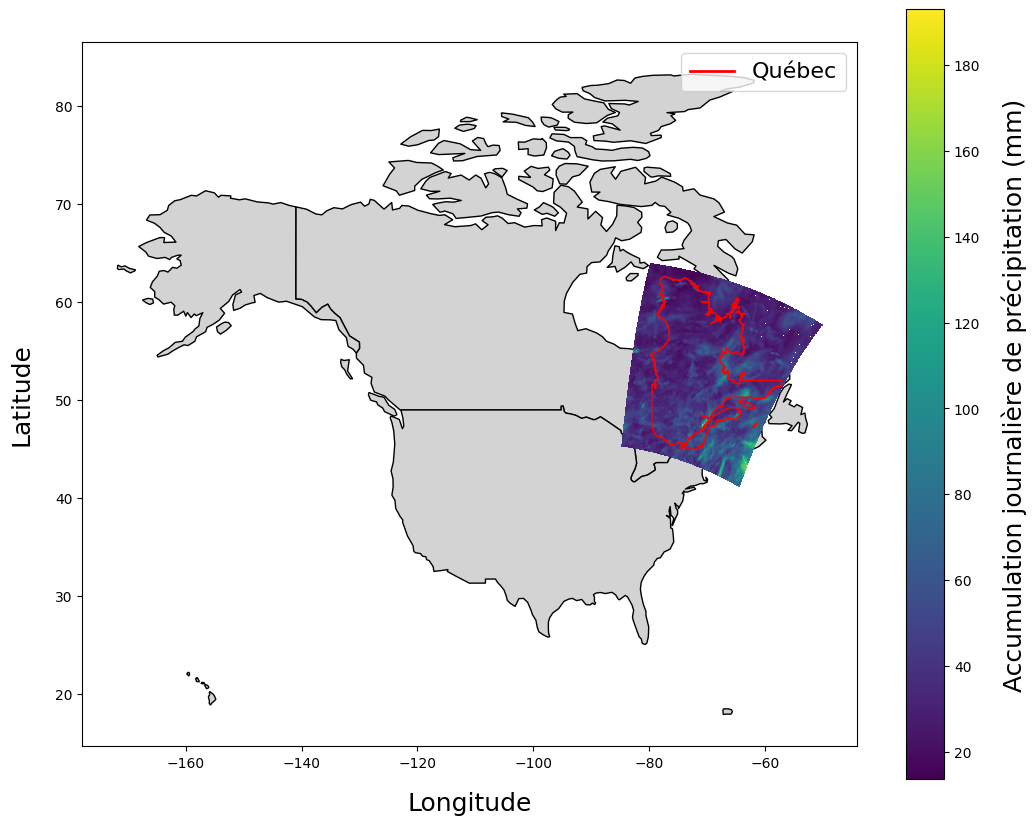

In [ ]:
from matplotlib.lines import Line2D

fontsize = 18

fig, ax = plt.subplots(figsize=(12.5, 10))

north_america.plot(ax=ax, color="lightgray", edgecolor="black")
sc = ax.scatter(
    flat_lons, flat_lats,
    c=flat_precips,
    cmap='viridis',
    marker='s',
    s=.7,
    edgecolor='none',
)
provinces.plot(ax=ax, color="none", edgecolor="red")

legend_handle = Line2D([0], [0], color='red', lw=2, label='Québec')

plt.legend(handles=[legend_handle], fontsize=fontsize-2)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Accumulation journalière de précipitation (mm)', fontsize=fontsize, labelpad=15)

# ax.set_title("Réanalyse CaSR", fontsize=14, y=1.05)
ax.set_xlabel("Longitude", fontsize=fontsize, labelpad=15)
ax.set_ylabel("Latitude", fontsize=fontsize, labelpad=15)

plt.savefig("heatmaps/overall.png", dpi=300)

## Cellule témoin

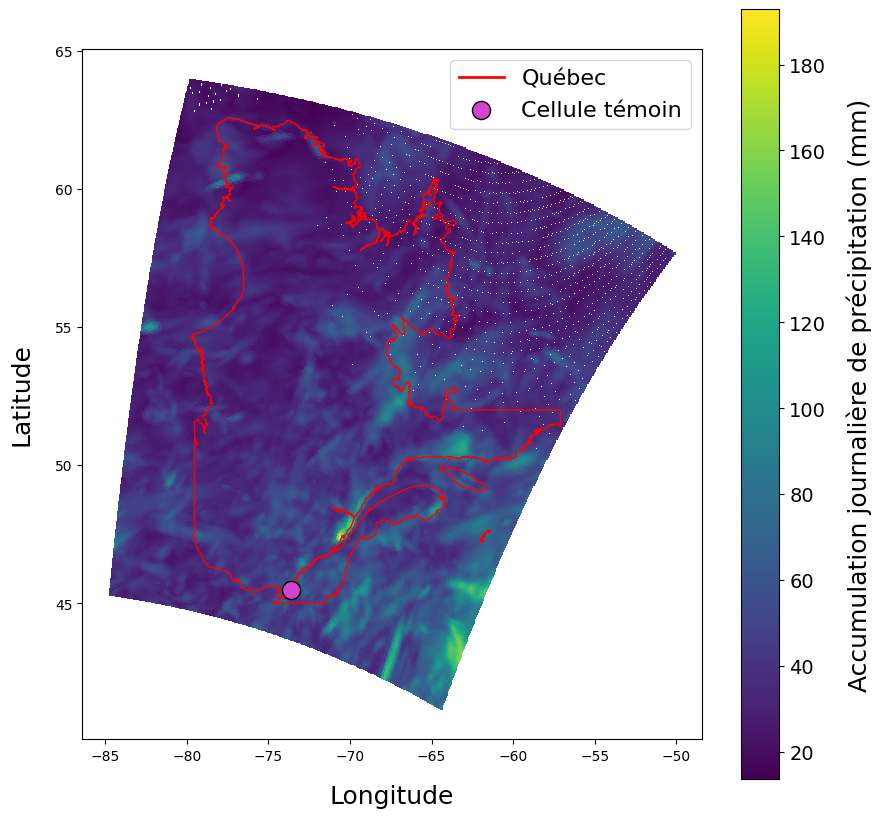

In [ ]:
from matplotlib.lines import Line2D

fontsize = 18

fig, ax = plt.subplots(figsize=(10, 10))

scRec = ax.scatter(
    flat_lons, flat_lats,
    c=flat_precips,
    cmap='viridis',
    marker='s',
    s=5,
    edgecolor='none',
)
provinces.plot(ax=ax, color="none", edgecolor="red", label="Québec")
sc = ax.scatter(
    -73.61365, 45.49225,
    c="#d145d0",
    s=170,
    ec="black",
    label="Cellule témoin",
)

legend_handle = Line2D([0], [0], color='red', lw=2, label='Québec')

plt.legend(handles=[legend_handle, sc], fontsize=fontsize-2)

cbar = plt.colorbar(scRec, ax=ax)
cbar.set_label('Accumulation journalière de précipitation (mm)', fontsize=fontsize, labelpad=15)
cbar.ax.tick_params(labelsize=fontsize-4)

# ax.set_title("Réanalyse CaSR : maxima 2022", fontsize=fontsize+4, y=1.05)
ax.set_xlabel("Longitude", fontsize=fontsize, labelpad=15)
ax.set_ylabel("Latitude", fontsize=fontsize, labelpad=15)

plt.savefig("heatmaps/montreal.png", dpi=300)

---
# Heatmap des paramètres GEV estimés

In [11]:
loadingFolder = "results/casr"

mu_sqavi_estimates = np.fromfile(loadingFolder + '/mu_sqavi_estimates.bin')
mu_mcmc_estimates = np.fromfile(loadingFolder + '/mu_mcmc_estimates.bin')
sigma_sqavi_estimates = np.exp(np.fromfile(loadingFolder + '/phi_sqavi_estimates.bin'))
sigma_mcmc_estimates = np.exp(np.fromfile(loadingFolder + '/phi_mcmc_estimates.bin'))

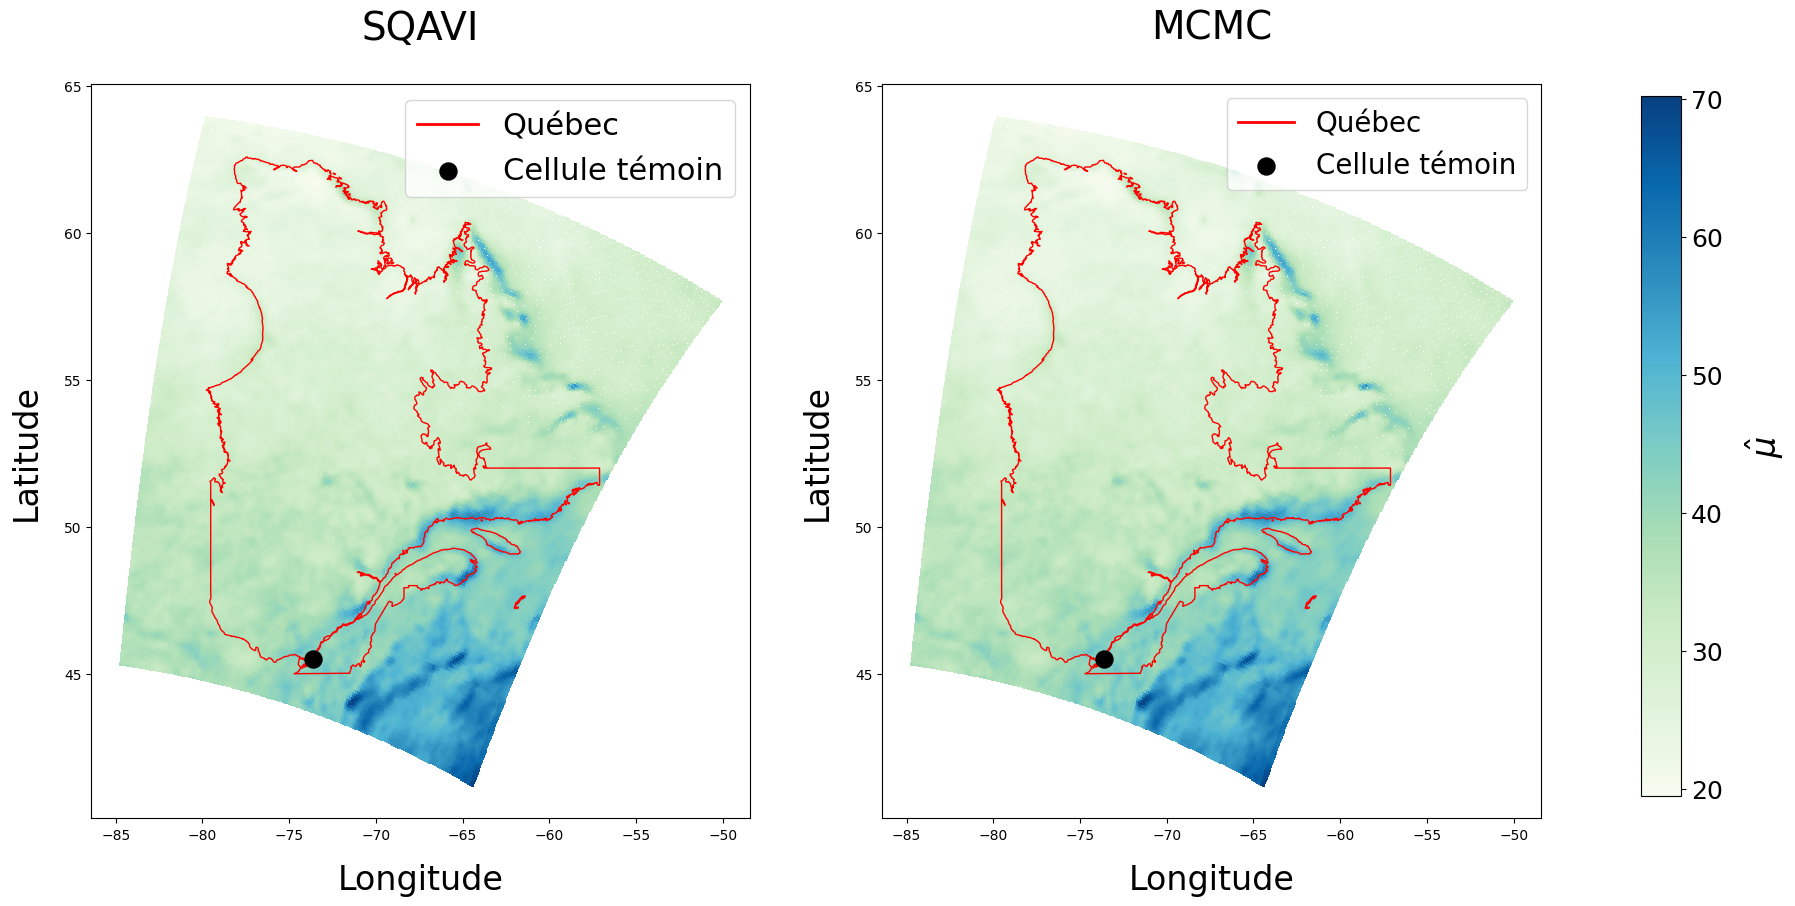

In [ ]:
from matplotlib.lines import Line2D

vmin = min(min(mu_sqavi_estimates), min(mu_mcmc_estimates))
vmax = max(max(mu_sqavi_estimates), max(mu_mcmc_estimates))

fontsize = 24

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

legend_handle = Line2D([0], [0], color='red', lw=2, label='Québec')

# Carte 1
sc1 = ax1.scatter(
    flat_lons, flat_lats,
    c=mu_sqavi_estimates,
    cmap='GnBu',
    marker='s',
    s=6,
    edgecolor='none',
    vmin=vmin,
    vmax=vmax,
)
provinces.plot(ax=ax1, color="none", edgecolor="red")
scMTL1 = ax1.scatter(
    -73.61365, 45.49225,
    c="black",
    s=150,
    ec="black",
    label="Cellule témoin",
)

ax1.legend(handles=[legend_handle, scMTL1], fontsize=fontsize-2)

ax1.set_title("SQAVI", fontsize=fontsize+4, y=1.05)
ax1.set_xlabel("Longitude", fontsize=fontsize, labelpad=15)
ax1.set_ylabel("Latitude", fontsize=fontsize, labelpad=15)

# Carte 2
sc2 = ax2.scatter(
    flat_lons, flat_lats,
    c=mu_mcmc_estimates,
    cmap='GnBu',
    marker='s',
    s=6,
    edgecolor='none',
    vmin=vmin,
    vmax=vmax,
)
provinces.plot(ax=ax2, color="none", edgecolor="red")
scMTL2 = ax2.scatter(
    -73.61365, 45.49225,
    c="black",
    s=150,
    ec="black",
    label="Cellule témoin",
)

ax2.set_title("MCMC", fontsize=fontsize+4, y=1.05)
ax2.set_xlabel("Longitude", fontsize=fontsize, labelpad=15)
ax2.set_ylabel("Latitude", fontsize=fontsize, labelpad=15)

ax2.legend(handles=[legend_handle, scMTL2], fontsize=fontsize-4)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc2, cax=cbar_ax)
cbar.set_label("$\hat{\mu}$", fontsize=fontsize, labelpad=15)
cbar.ax.tick_params(labelsize=fontsize-6)

plt.savefig("heatmaps/mu_heatmaps.png", dpi=300)

---
# Heatmap des niveaux de retour associés à la période de retour 100 ans

In [14]:
loadingFolder = "results/casr"

mu_sqavi_estimates = np.fromfile(loadingFolder + '/mu_sqavi_estimates.bin')
mu_mcmc_estimates = np.fromfile(loadingFolder + '/mu_mcmc_estimates.bin')
sigma_sqavi_estimates = np.exp(np.fromfile(loadingFolder + '/phi_sqavi_estimates.bin'))
sigma_mcmc_estimates = np.exp(np.fromfile(loadingFolder + '/phi_mcmc_estimates.bin'))
xi_sqavi_estimate = 0.0645946672662075
xi_mcmc_estimate = 0.058058437746817126

In [15]:
return_level_sqavi = viz.computeReturnLevel(100, mu=mu_sqavi_estimates, sigma=sigma_sqavi_estimates, xi=xi_sqavi_estimate)
return_level_mcmc = viz.computeReturnLevel(100, mu=mu_mcmc_estimates, sigma=sigma_mcmc_estimates, xi=xi_mcmc_estimate)

delta_return_levels = return_level_sqavi - return_level_mcmc

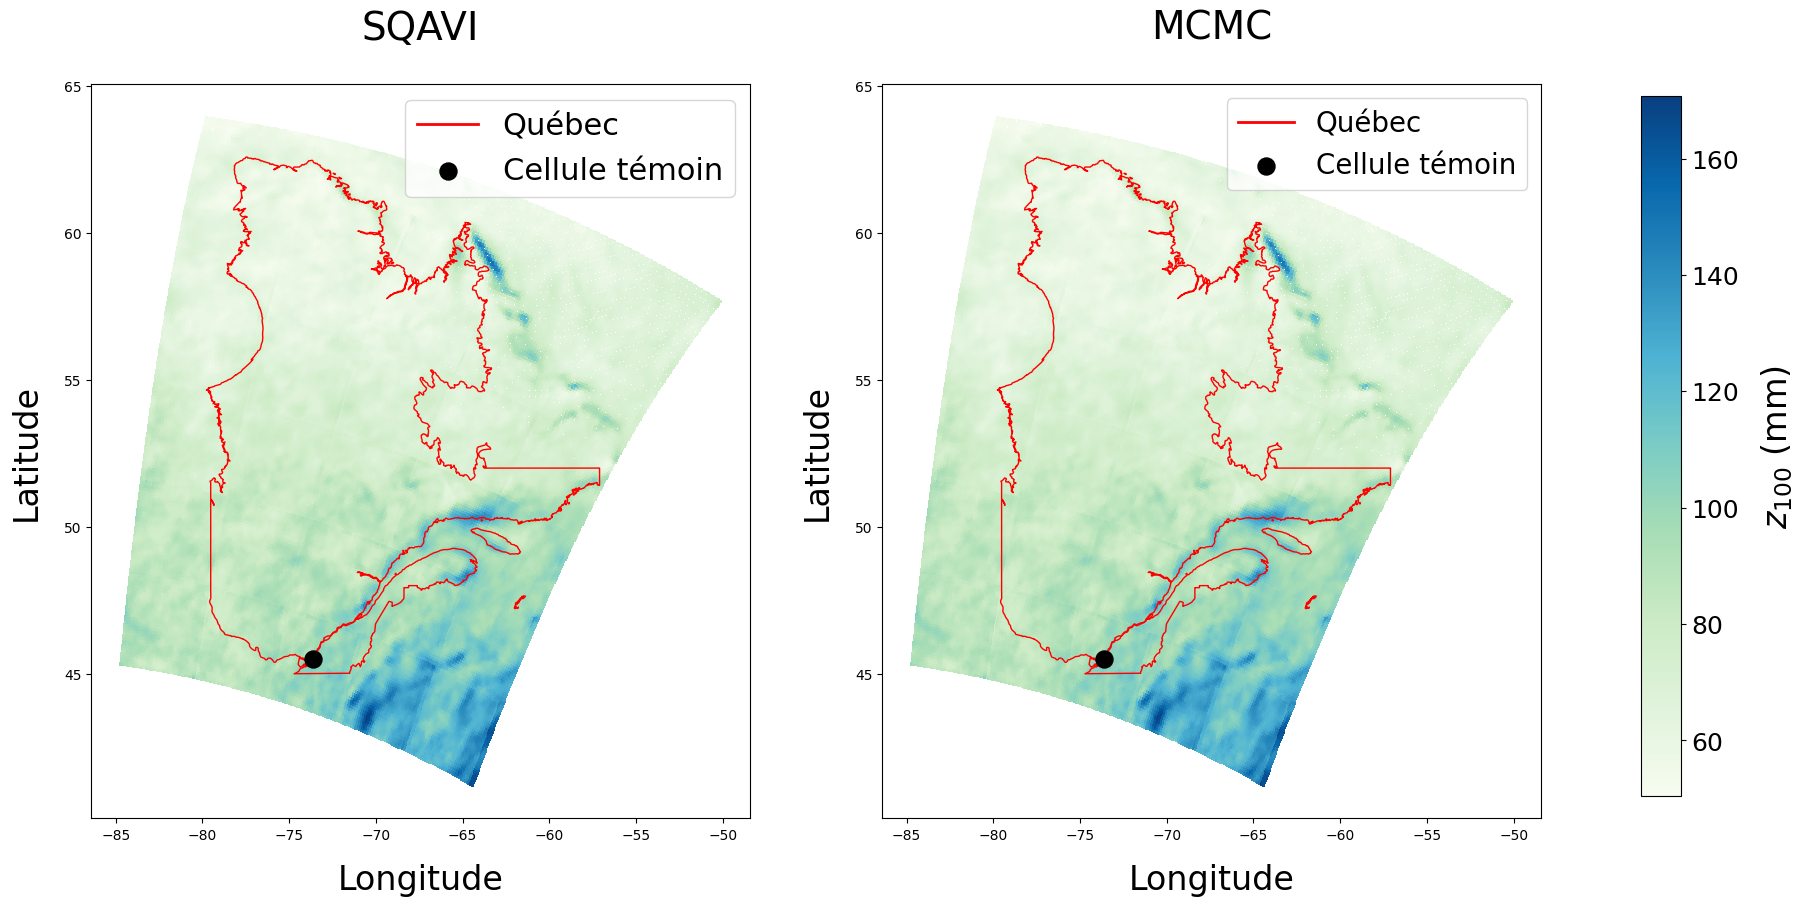

In [ ]:
from matplotlib.lines import Line2D

vmin = min(min(return_level_sqavi), min(return_level_mcmc))
vmax = max(max(return_level_sqavi), max(return_level_mcmc))

fontsize = 24

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

legend_handle = Line2D([0], [0], color='red', lw=2, label='Québec')

# Carte 1
sc1 = ax1.scatter(
    flat_lons, flat_lats,
    c=return_level_sqavi,
    cmap='GnBu',
    marker='s',
    s=6,
    edgecolor='none',
    vmin=vmin,
    vmax=vmax,
)
provinces.plot(ax=ax1, color="none", edgecolor="red")
scMTL1 = ax1.scatter(
    -73.61365, 45.49225,
    c="black",
    s=150,
    ec="black",
    label="Cellule témoin",
)

ax1.legend(handles=[legend_handle, scMTL1], fontsize=fontsize-2)

ax1.set_title("SQAVI", fontsize=fontsize+4, y=1.05)
ax1.set_xlabel("Longitude", fontsize=fontsize, labelpad=15)
ax1.set_ylabel("Latitude", fontsize=fontsize, labelpad=15)

# Carte 2
sc2 = ax2.scatter(
    flat_lons, flat_lats,
    c=return_level_mcmc,
    cmap='GnBu',
    marker='s',
    s=6,
    edgecolor='none',
    vmin=vmin,
    vmax=vmax,
)
provinces.plot(ax=ax2, color="none", edgecolor="red")
scMTL2 = ax2.scatter(
    -73.61365, 45.49225,
    c="black",
    s=150,
    ec="black",
    label="Cellule témoin",
)

ax2.set_title("MCMC", fontsize=fontsize+4, y=1.05)
ax2.set_xlabel("Longitude", fontsize=fontsize, labelpad=15)
ax2.set_ylabel("Latitude", fontsize=fontsize, labelpad=15)

ax2.legend(handles=[legend_handle, scMTL2], fontsize=fontsize-4)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc2, cax=cbar_ax)
cbar.set_label("$z_{100}$ (mm)", fontsize=fontsize, labelpad=15)
cbar.ax.tick_params(labelsize=fontsize-6)

plt.savefig("heatmaps/return_levels.png", dpi=300)

Delta entre ces niveaux de retour

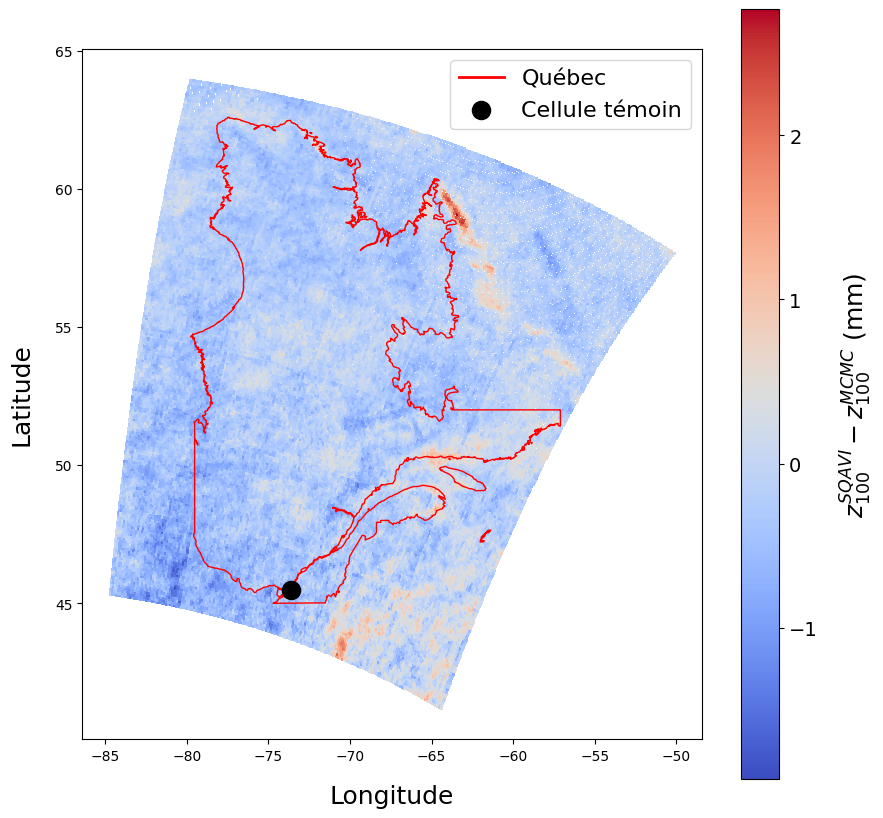

In [ ]:
from matplotlib.lines import Line2D

fontsize = 18

fig, ax = plt.subplots(figsize=(10, 10))

scReturnLevel = ax.scatter(
    flat_lons, flat_lats,
    c=delta_return_levels,
    cmap='coolwarm',
    marker='s',
    s=5,
    edgecolor='none',
)
provinces.plot(ax=ax, color="none", edgecolor="red", label="Québec")
sc = ax.scatter(
    -73.61365, 45.49225,
    c="black",
    s=170,
    ec="black",
    label="Cellule témoin",
)

legend_handle = Line2D([0], [0], color='red', lw=2, label='Québec')

plt.legend(handles=[legend_handle, sc], fontsize=fontsize-2)

cbar = plt.colorbar(scReturnLevel, ax=ax)
cbar.set_label("$z^{SQAVI}_{100} - z^{MCMC}_{100}$ (mm)", fontsize=fontsize, labelpad=15)
cbar.ax.tick_params(labelsize=fontsize-4)

# ax.set_title("Réanalyse CaSR : maxima 2022", fontsize=fontsize+4, y=1.05)
ax.set_xlabel("Longitude", fontsize=fontsize, labelpad=15)
ax.set_ylabel("Latitude", fontsize=fontsize, labelpad=15)

plt.savefig("heatmaps/delta_return_levels.png", dpi=300)